In [3]:
from google.colab import drive
drive.mount('/content/drive')



#datasets = load_data(user_ids, path_to_data)
#train_on_clients(datasets)

Mounted at /content/drive


In [4]:


import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
path_to_data_X = 'drive/MyDrive/Colab Notebooks/train_X.npy'
path_to_data_y = 'drive/MyDrive/Colab Notebooks/train_y.npy'
path_to_data_test_X = 'drive/MyDrive/Colab Notebooks/test_X.npy'
path_to_data_test_y = 'drive/MyDrive/Colab Notebooks/test_y.npy'
datasets_X = np.load(path_to_data_X, allow_pickle=True)
datasets_y = np.load(path_to_data_y, allow_pickle=True)
test_X = np.load(path_to_data_test_X, allow_pickle=True)
test_y = np.load(path_to_data_test_y, allow_pickle=True)

In [6]:
datasets = {}
datasets['images'] = datasets_X
datasets['labels'] = datasets_y
test_datasets = {}
test_datasets['images'] = test_X
test_datasets['labels'] = test_y

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self,act):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        if act == 'RELU':
          self.relu = nn.ReLU()
        elif act == 'sigmoid':
          self.relu = nn.Sigmoid()
        else:
          self.relu = nn.Tanh()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create a model instance
# model = SimpleNN()


In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [9]:
from sklearn.metrics import f1_score

In [10]:
def evaluate_fitness(chromosome, datasets, test_datasets, num_epochs=20):
    mini_batch_size, activation_function = chromosome
    model = SimpleNN(activation_function)  # Define your model architecture here
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Modify your train_loader to use the new mini_batch_size
    #train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

    for epoch in range(num_epochs):
        # Train your model for one epoch
        # ...
        models = []
        tmp_loss = 0
        tmp_accuracy = 0

        data = torch.tensor(datasets['images'])
        target = torch.tensor(datasets['labels']).type(torch.LongTensor)
        for batch in iterate_minibatches(data, target, mini_batch_size, shuffle=True):
      # Split batch to get batch data and labels
          batch_data, batch_labels = batch

        # Forward pass
          outputs = model(batch_data)
          loss = criterion(outputs, batch_labels)

          #Backward pass and optimization
          optimizer.zero_grad()  # Clear existing gradients
          loss.backward()        # Compute gradients
          optimizer.step()       # Update parameters

    # Evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        # Calculate F1 score on validation set
        # ...
        data = torch.tensor(test_datasets['images'])
        target = torch.tensor(test_datasets['labels']).type(torch.LongTensor)
        true_labels.extend(target.tolist())
        output = model(data)
        predictions.extend(torch.argmax(output,dim=1).tolist())
        val_f1_score = f1_score(true_labels, predictions, average='macro')

    return val_f1_score


In [11]:
def roulette_wheel_selection(population, fitness_scores):
    total_fitness = sum(fitness_scores)
    selection_probs = [f / total_fitness for f in fitness_scores]
    selected_indices = np.random.choice(range(len(population)), size=len(population)//2, p=selection_probs)
    return [population[i] for i in selected_indices]


In [12]:
def one_point_crossover(selected):
    offspring = []
    for i in range(0, len(selected), 2):
        parent1, parent2 = selected[i], selected[i+1]
        crossover_point = random.randint(1, len(parent1) - 1)  # Assuming len(parent) > 1
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        offspring.extend([child1, child2])
    return offspring


In [13]:
def mutate(offspring, mutation_rate):
    for i in range(len(offspring)):
        if random.random() < mutation_rate:
            gene_to_mutate = random.choice([0, 1])  # Choose which gene to mutate
            if gene_to_mutate == 0:  # Mutate mini_batch_size
                offspring[i] = (random.randint(*batch_size_range), offspring[i][1])
            else:  # Mutate activation_function
                offspring[i] = (offspring[i][0], random.choice(activation_functions))
    return offspring


In [14]:
def age_based_selection(old_population, offspring,datasets,test_datasets):
    # Combine old population and offspring
    combined_population = old_population + offspring

    # Sort based on fitness (and possibly age)
    combined_population.sort(key=lambda chromosome: evaluate_fitness(chromosome,datasets, test_datasets), reverse=True)

    # Select the top N chromosomes for the next generation
    new_population = combined_population[:len(old_population)]
    return new_population


In [15]:
import random


# Define the chromosome structure and initial parameters
population_size = 100
generations = 100
mutation_rate = 0.1
activation_functions = ['RELU', 'sigmoid', 'tanh']
batch_size_range = (16, 1024)

# Initialize population
population = [(random.randint(*batch_size_range), random.choice(activation_functions)) for _ in range(population_size)]
results = []
avg_results = []

for generation in range(generations):
    # Evaluate fitness for each chromosome
    fitness_scores = [evaluate_fitness(chromosome, datasets, test_datasets) for chromosome in population]
    results.append(np.max(fitness_scores))
    avg_results.append(np.mean(fitness_scores))

    # Selection (Roulette Rule)
    selected = roulette_wheel_selection(population, fitness_scores)

    # Crossover (One-Point Crossover)
    offspring = one_point_crossover(selected)

    # Mutation
    mutated_offspring = mutate(offspring, mutation_rate)

    # Age-Based Selection
    population = age_based_selection(population, mutated_offspring,datasets,test_datasets)



# Find the best chromosome
best_chromosome = max(population, key=evaluate_fitness)


KeyboardInterrupt: ignored

In [18]:
results

[0.8573359817479688,
 0.8645237847002107,
 0.8553008760239565,
 0.8646092626200794,
 0.865595465627057,
 0.8597543722263603,
 0.8665551729965368,
 0.8628618253078676]

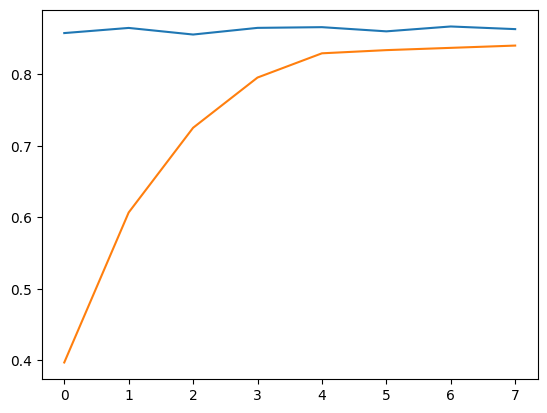

In [19]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(results))

plt.plot(xpoints, results, avg_results)
plt.show()

In [21]:
population[7]

(50, 'RELU')

In [22]:

def train_fitness(chromosome, datasets, test_datasets, num_epochs=100):
    mini_batch_size, activation_function = chromosome
    lists = ['RELU', 'sigmoid', 'tanh']
    model = SimpleNN('RELU')  # Define your model architecture here
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Modify your train_loader to use the new mini_batch_size
    #train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

    f1 = []
    for epoch in range(num_epochs):
        # Train your model for one epoch
        # ...
        models = []
        tmp_loss = 0
        tmp_accuracy = 0
        predictions = []
        true_labels = []

        data = torch.tensor(datasets['images'])
        target = torch.tensor(datasets['labels']).type(torch.LongTensor)
        for batch in iterate_minibatches(data, target, mini_batch_size, shuffle=True):
      # Split batch to get batch data and labels
          batch_data, batch_labels = batch

        # Forward pass
          outputs = model(batch_data)
          loss = criterion(outputs, batch_labels)
          pred = torch.argmax(outputs,dim=1)


          #Backward pass and optimization
          optimizer.zero_grad()  # Clear existing gradients
          loss.backward()        # Compute gradients
          optimizer.step()       # Update parameters
          with torch.no_grad():
            predictions.extend(torch.argmax(outputs,dim=1).tolist())
            true_labels.extend(batch_labels.tolist())
        f1.append(f1_score(true_labels, predictions, average='macro'))

    # Evaluate on validation set
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        # Calculate F1 score on validation set
        # ...
        data = torch.tensor(test_datasets['images'])
        target = torch.tensor(test_datasets['labels']).type(torch.LongTensor)
        true_labels.extend(target.tolist())
        output = model(data)
        predictions.extend(torch.argmax(output,dim=1).tolist())
        val_f1_score = f1_score(true_labels, predictions, average='macro')

    return f1
chromosome = (50,'RELU')
f1 = train_fitness(chromosome, datasets, test_datasets)

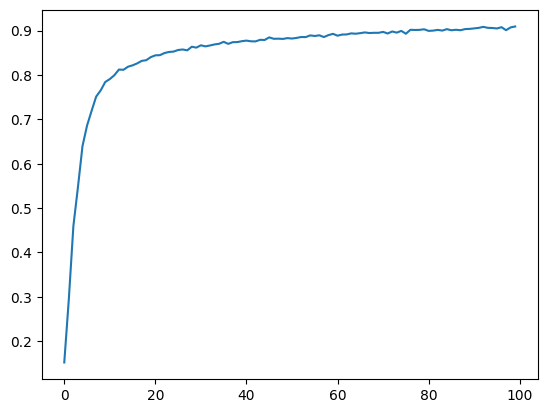

In [23]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(f1))

plt.plot(xpoints, f1)
plt.show()